# Deep Ritz method, DeepONet

2024년 여름 대학생을 위한 인공지능 튜토리얼 - 과학기계학습 맛보기

2024년 7월 18일 실습

In [1]:
from collections.abc import Callable, Sequence
from functools import partial

import flax.linen as nn
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import optax
from tqdm.auto import tqdm

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
plt.rcParams.update({"figure.constrained_layout.use": True})
# jax 불러오고, flax 불러오고, optax 불러오고.

In [2]:
class MLP(nn.Module):
    features: Sequence[int]
    activation: Callable = jnp.tanh
    # 요부분이 data class에 해당하는 부분이에요.
    # 기존의 data class는 초기화(initial) 하는 값과

    @nn.compact
    def __call__(self, x):
        for i, out_features in enumerate(self.features):
            x = nn.Dense(
                out_features, kernel_init=nn.initializers.lecun_normal()
            )(x)
            if i < len(self.features) - 1:
                x = self.activation(x)
        return x

참고: Flax의 인공 신경망 모듈은 [파이썬 데이터 클래스](https://docs.python.org/3/library/dataclasses.html)입니다.
데이터 클래스의 여러 쓰임새 중 대표적인 기능으로, 어트리뷰트의 이름만 지정하면, 클래스의 인스턴스를 만들 때 인자를 전부 복사해 주는 `__init__` 함수(클래스의 객체를 만들 때 불리는 함수)를 자동으로 만들어 주는 기능이 있습니다.

In [3]:
class NormalClassRectangle:
    def __init__(self, width, height, color="흰색"):
        self.width = width
        self.height = height
        self.color = color

        self.area = self.width * self.height

    def summary(self):
        return f"너비: {self.width}, 높이: {self.height}, 넓이: {self.area}, 색깔: {self.color}"

my_rectangle = NormalClassRectangle(width=3, height=4)
my_rectangle.summary()

'너비: 3, 높이: 4, 넓이: 12, 색깔: 흰색'

In [4]:
from dataclasses import dataclass, is_dataclass

@dataclass
class DataClassRectangle:
    width: int
    height: int
    color: str = "흰색"

    def __post_init__(self):
        self.area = self.width * self.height

    def summary(self):
        return f"너비: {self.width}, 높이: {self.height}, 넓이: {self.area}, 색깔: {self.color}"

my_rectangle = DataClassRectangle(width=3, height=4)
my_rectangle.summary()

'너비: 3, 높이: 4, 넓이: 12, 색깔: 흰색'

In [5]:
print(f"{is_dataclass(NormalClassRectangle) = }")
print(f"{is_dataclass(DataClassRectangle) = }")
print(f"{is_dataclass(nn.Dense) = }")
print(f"{is_dataclass(MLP) = }")

is_dataclass(NormalClassRectangle) = False
is_dataclass(DataClassRectangle) = True
is_dataclass(nn.Dense) = True
is_dataclass(MLP) = True


## Deep Ritz method: 2D Poisson’s eqation

정의역:

$$
\Omega = (-1, 1) \times (-1, 1) \setminus [0, 1) \times \{0\}
$$

미분 방정식: ($x$가 2D)

$$
-\Delta u(x) = 1, \quad x \in \Omega \\
u(x) = 0, \quad x \in \partial\Omega
$$

모델:

$$
u^\theta(x) = \operatorname{Ritz}^\theta(x)
$$

손실 함수:

$$
L(\theta) = \int_\Omega \frac12 \lVert \nabla u^\theta(x_i) \rVert^2 - u^\theta(x_i) \; \mathrm{d}x + \beta \int_{\partial\Omega} u^\theta(x_i)^2 \; \mathrm{d}s
$$

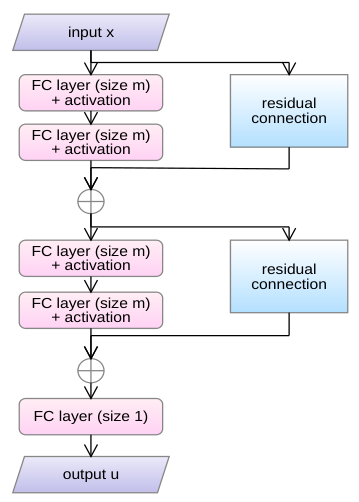

Deep Ritz method 논문에 나온 구조를 구현합니다. (FC = fully connected) FC 다음에 activation에 input data를 더하는거에요. residual connection을 달아주었더니 엄청 잘되더라.

In [6]:
class RitzBlock(nn.Module):
    features: int
    activation: Callable

    @nn.compact
    def __call__(self, x):
        x_copied = x # 맨처음에 들어온 값을 복사해놨다가
        for i in range(2):
            x = nn.Dense(
                self.features, kernel_init=nn.initializers.lecun_normal()
            )(x)
            x = self.activation(x)

        if x_copied.size < x.size:
            x_copied = jnp.concatenate([
                x_copied,
                jnp.zeros(x.size - x_copied.size),
            ])

        return x + x_copied # 여기에 붙이는거에요.


class RitzNet(nn.Module):
    n_blocks: int
    features: int
    activation: Callable = jnp.tanh

    @nn.compact
    # compact라는 문법을 쓰면, parameter가 없어도, 함수를 쭈욱 보고
    # dense 안에 parameter가 있을테니까 그것들을 잘 묶어놨다가
    # 한 번에 dictionary로 던져주는거에요.
    # 그래디언트 계산할때도 요 모양 그대로 다시 돌려줘요.
    def __call__(self, x):
        for i in range(self.n_blocks):
            x = RitzBlock(features=self.features, activation=self.activation)(
                x
            )
        x = nn.Dense(1, kernel_init=nn.initializers.lecun_normal())(x)
        return x

In [7]:
# 파라미터 모양 확인
model = RitzNet(n_blocks=4, features=10)
params = model.init(jax.random.key(78), jnp.zeros((2,)))

print("총 파라미터 수:", jax.tree.reduce(lambda s, x: s + x.size, params, 0))
jax.tree.map(lambda x: x.shape, params)

총 파라미터 수: 811


{'params': {'Dense_0': {'bias': (1,), 'kernel': (10, 1)},
  'RitzBlock_0': {'Dense_0': {'bias': (10,), 'kernel': (2, 10)},
   'Dense_1': {'bias': (10,), 'kernel': (10, 10)}},
  'RitzBlock_1': {'Dense_0': {'bias': (10,), 'kernel': (10, 10)},
   'Dense_1': {'bias': (10,), 'kernel': (10, 10)}},
  'RitzBlock_2': {'Dense_0': {'bias': (10,), 'kernel': (10, 10)},
   'Dense_1': {'bias': (10,), 'kernel': (10, 10)}},
  'RitzBlock_3': {'Dense_0': {'bias': (10,), 'kernel': (10, 10)},
   'Dense_1': {'bias': (10,), 'kernel': (10, 10)}}}}

In [8]:
# 문제와 모델 설정
# 참고: 논문에는 활성화 함수로 max(x^3, 0)을 썼다는데 잘 안됨
#     def cube_ramp(x):
#         return jnp.clip(x**3, 0)
ritz_net = RitzNet(n_blocks=4, features=10)

# (2,) -> ()
def poisson_u(params, xy):
    return ritz_net.apply(params, xy).reshape()

# (2,) -> ()
def poisson_ritz_pde(params, xy):
    u_value = poisson_u(params, xy)
    grad_u_value = jax.jacfwd(poisson_u, argnums=1)(params, xy)  # shape (2,)

    return 0.5 * (grad_u_value**2).sum() - u_value

# (N_interior, 2), (N_boundary, 2) -> ()
def poisson_ritz_loss(params, xy_interior, xy_boundary, beta):
    # 손실 함수에 나오는 적분을 계산하는 대신
    # 단순하게 샘플 피적분함숫값의 평균을 취함.
    # 정의역의 크기나 경계의 길이에 따라 기댓값이 실제 적분값과
    # 상수 배 차이가 나긴 하지만, 훈련하는 데에 문제는 없음
    ritz_physics_loss = jax.vmap(poisson_ritz_pde, in_axes=(None, 0))(
        params, xy_interior
    ).mean()
    ritz_boundary_loss = (
        jax.vmap(poisson_u, in_axes=(None, 0))(params, xy_boundary) ** 2
    ).mean()

    total_loss = ritz_physics_loss + beta * ritz_boundary_loss
    return total_loss, (ritz_physics_loss, ritz_boundary_loss)

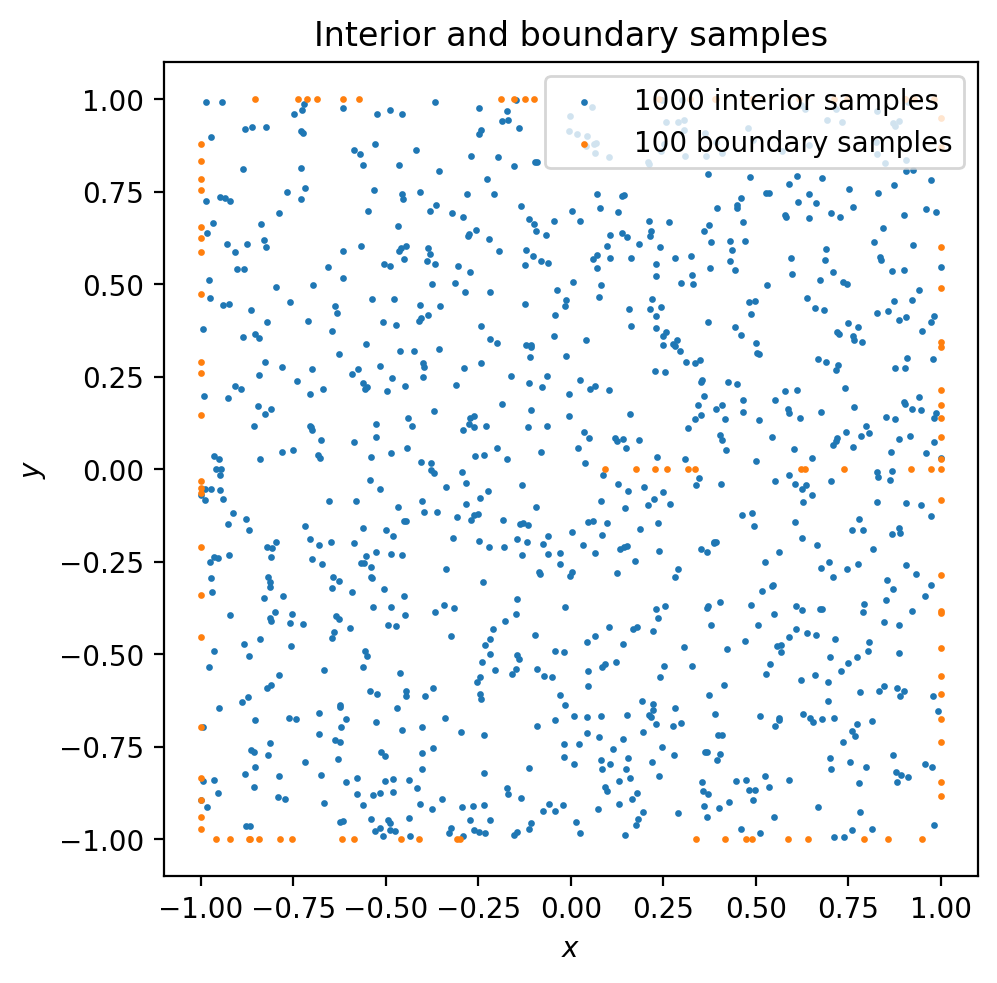

In [9]:
# 샘플링
# Loss function에서 integral을 잘 하면 좋은데, 그게 안되니까
# sampling points를 뽑은다음에 평균을 취해서 loss를 줄일거에요.
@partial(jax.jit, static_argnums=(1,))
def sample_cracked_interior(key, n_samples):
    return jax.random.uniform(key, shape=(n_samples, 2), minval=-1, maxval=1)

@partial(jax.jit, static_argnums=(1,))
def sample_cracked_boundary(key, n_samples):
    outside_key, inside_key = jax.random.split(key)

    n_outside_samples = n_samples // 9 * 2  # 바깥쪽 한 변의 샘플수
    n_inside_samples = n_samples - 4 * n_outside_samples

    top_x, bottom_x, left_y, right_y = jax.random.uniform(
        outside_key, shape=(4, n_outside_samples), minval=-1, maxval=1
    )
    inside_x = jax.random.uniform(
        inside_key, shape=(n_inside_samples,), minval=0, maxval=1
    )

    return jnp.concatenate([
        jnp.column_stack([bottom_x, jnp.full_like(bottom_x, -1.0)]),
        jnp.column_stack([top_x, jnp.full_like(top_x, 1.0)]),
        jnp.column_stack([jnp.full_like(left_y, -1.0), left_y]),
        jnp.column_stack([jnp.full_like(right_y, 1.0), right_y]),
        jnp.column_stack([inside_x, jnp.zeros_like(inside_x)]),
    ])

interior_key, boundary_key = jax.random.split(jax.random.key(78))
xy_interior = sample_cracked_interior(interior_key, n_samples=1000)
xy_boundary = sample_cracked_boundary(interior_key, n_samples=100)

fig, ax = plt.subplots()
ax.scatter(
    xy_interior[:, 0],
    xy_interior[:, 1],
    s=2,
    label=f"{xy_interior.shape[0]} interior samples",
)
ax.scatter(
    xy_boundary[:, 0],
    xy_boundary[:, 1],
    s=2,
    label=f"{xy_boundary.shape[0]} boundary samples",
)
ax.legend()
ax.axis("square")
ax.set(xlabel=R"$x$", ylabel=R"$y$", title="Interior and boundary samples")
pass


In [10]:
# 훈련 설정
model_key, data_key = jax.random.split(jax.random.key(78))
n_epochs = 30_000
learning_rate = optax.cosine_decay_schedule(3e-3, decay_steps=n_epochs)
n_interior_samples = 1000
n_boundary_samples = 100
boundary_loss_weight = 500
optimizer = optax.adam(learning_rate)

params = ritz_net.init(model_key, jnp.zeros((2,)))
optimizer_state = optimizer.init(params)

@jax.jit
def step(
    params, optimizer_state, xy_interior, xy_boundary, boundary_loss_weight
):
    loss, grads = jax.value_and_grad(poisson_ritz_loss, has_aux=True)(
        params, xy_interior, xy_boundary, boundary_loss_weight
    )
    updates, optimizer_state = optimizer.update(grads, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params, optimizer_state, loss

In [11]:
loss_history = []
physics_loss_history = []
boundary_loss_history = []

for i in tqdm(range(1, n_epochs + 1)):
    data_key, interior_key, boundary_key = jax.random.split(data_key, 3)
    xy_interior = sample_cracked_interior(interior_key, n_interior_samples)
    xy_boundary = sample_cracked_boundary(boundary_key, n_boundary_samples)

    params, optimizer_state, (loss_value, (physics_loss, boundary_loss)) = (
        step(
            params,
            optimizer_state,
            xy_interior,
            xy_boundary,
            boundary_loss_weight,
        )
    )
    loss_history.append(loss_value.item())
    physics_loss_history.append(physics_loss.item())
    boundary_loss_history.append(boundary_loss.item())
    if i % (n_epochs // 20) == 0:
        tqdm.write(f"Epoch {i}: {loss_value = :g}")

  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 1500: loss_value = -0.0103209
Epoch 3000: loss_value = -0.0089231
Epoch 4500: loss_value = -0.0302815
Epoch 6000: loss_value = -0.027993
Epoch 7500: loss_value = -0.0279944
Epoch 9000: loss_value = -0.0314643
Epoch 10500: loss_value = -0.032235
Epoch 12000: loss_value = -0.0336094
Epoch 13500: loss_value = -0.0341522
Epoch 15000: loss_value = -0.0363323
Epoch 16500: loss_value = -0.0398295
Epoch 18000: loss_value = -0.0391281
Epoch 19500: loss_value = -0.0418312
Epoch 21000: loss_value = -0.0376182
Epoch 22500: loss_value = -0.0378939
Epoch 24000: loss_value = -0.0381239
Epoch 25500: loss_value = -0.0441024
Epoch 27000: loss_value = -0.0415573
Epoch 28500: loss_value = -0.0422307
Epoch 30000: loss_value = -0.0419902


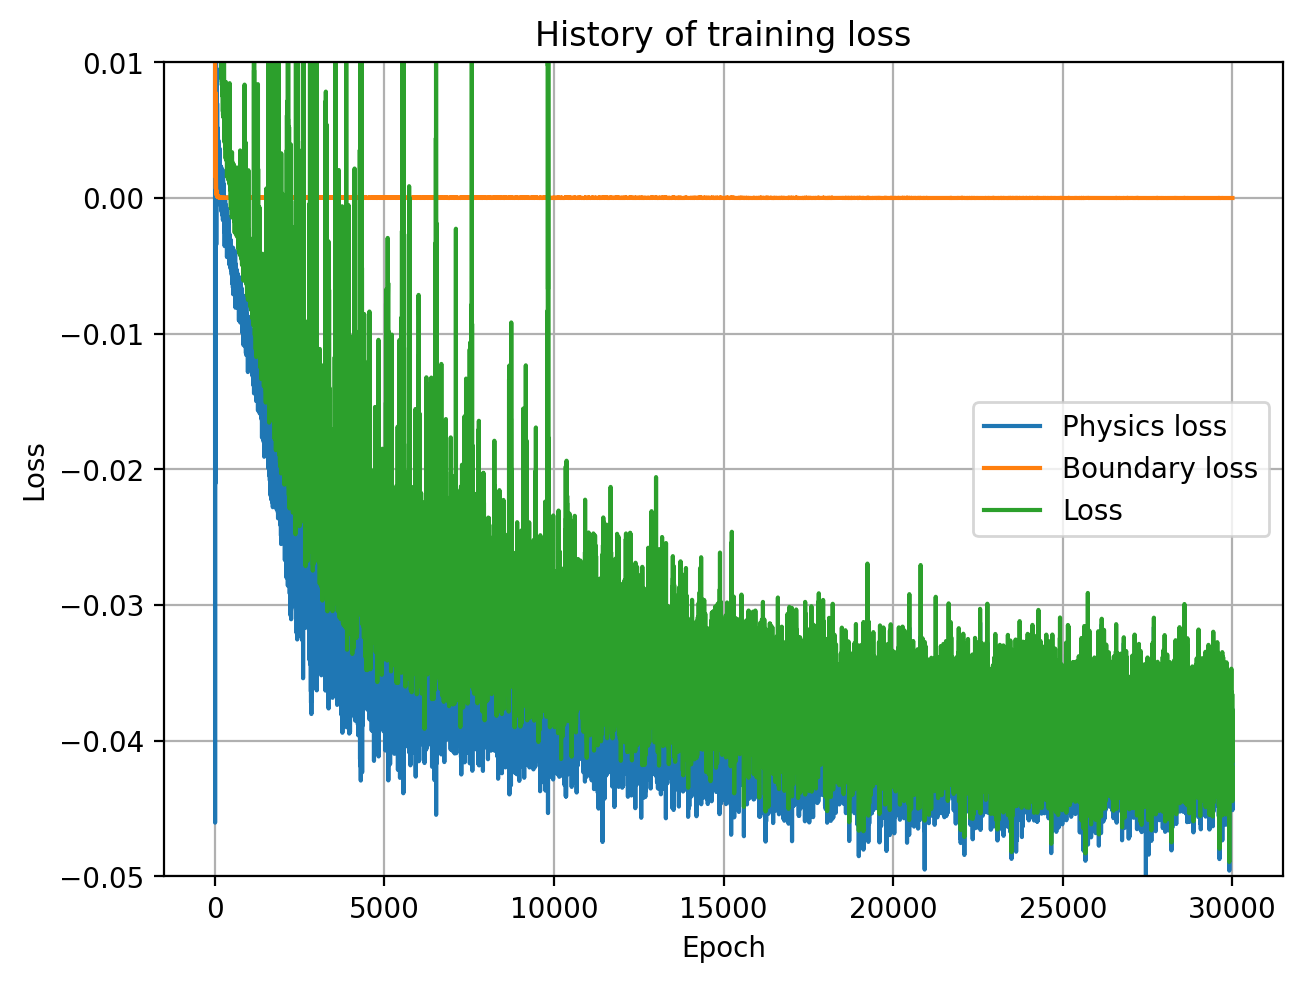

In [12]:
fig, ax = plt.subplots()
ax.plot(physics_loss_history, label="Physics loss")
ax.plot(boundary_loss_history, label="Boundary loss")
ax.plot(loss_history, label="Loss")
ax.set(
    xlabel="Epoch",
    ylabel="Loss",
    title="History of training loss",
)
ax.legend()
ax.grid()
ax.set_ylim((-0.05, 0.01))
pass

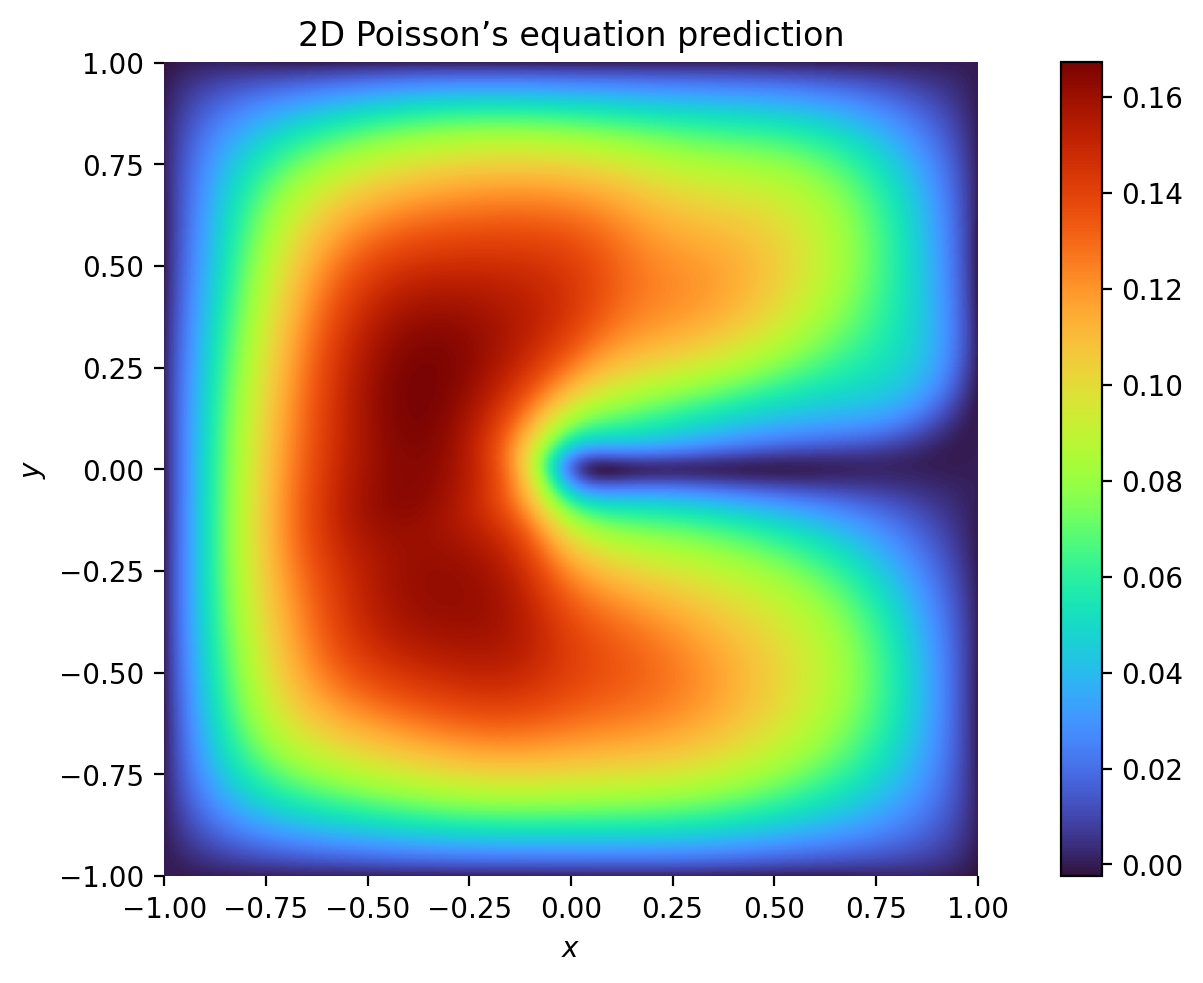

In [13]:
x = jnp.linspace(-1, 1, 1001)
y = jnp.linspace(-1, 1, 1001)

X, Y = jnp.meshgrid(x, y)

u = jax.vmap(poisson_u, in_axes=(None, 0))(
    params, jnp.column_stack([X.ravel(), Y.ravel()])
).reshape(X.shape)

fig, ax = plt.subplots()
pcolormesh = ax.pcolormesh(X, Y, u, cmap="turbo")
ax.spines[:].set_visible(False)
ax.axis("square")
fig.colorbar(pcolormesh, ax=ax)
ax.set(xlabel=R"$x$", ylabel=R"$y$", title="2D Poisson’s equation prediction")
pass

## DeepONet: 역도함수 오퍼레이터

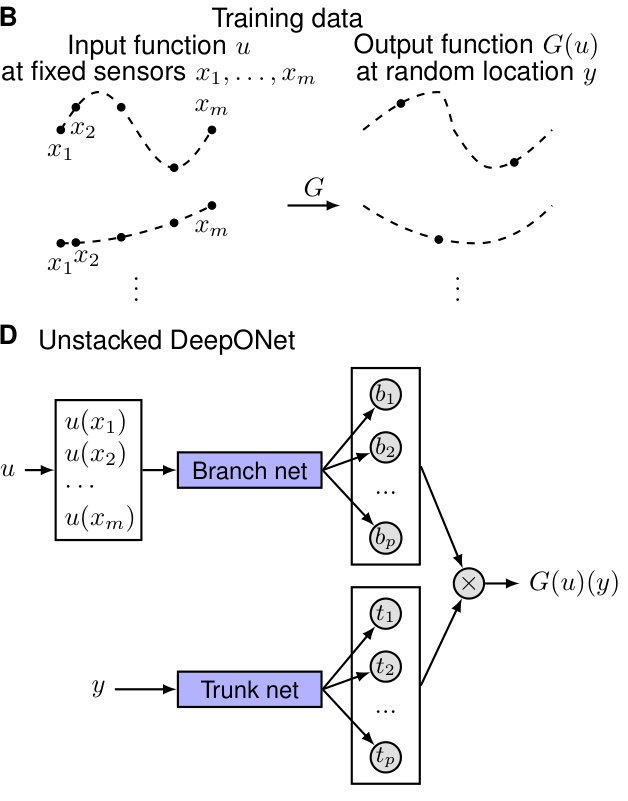

역도함수 오퍼레이터

$$
G : u \mapsto v \\
\frac{dv}{dx}(x) = u(x) \\
v(0) = 0
$$


In [14]:
# 데이터 불러 오기
!wget -nv https://github.com/mroberto166/CAMLab-DLSCTutorials/raw/main/antiderivative_aligned_train.npz
!wget -nv https://github.com/mroberto166/CAMLab-DLSCTutorials/raw/main/antiderivative_aligned_test.npz

2024-07-25 05:40:23 URL:https://raw.githubusercontent.com/mroberto166/CAMLab-DLSCTutorials/main/antiderivative_aligned_train.npz [241573/241573] -> "antiderivative_aligned_train.npz" [1]
2024-07-25 05:40:25 URL:https://raw.githubusercontent.com/mroberto166/CAMLab-DLSCTutorials/main/antiderivative_aligned_test.npz [1601574/1601574] -> "antiderivative_aligned_test.npz" [1]


In [15]:
with jnp.load("antiderivative_aligned_train.npz", allow_pickle=True) as train_data:
    u_train = jnp.asarray(train_data["X"][0], dtype=jnp.float32)
    y_train = jnp.asarray(train_data["X"][1], dtype=jnp.float32)
    v_train = jnp.asarray(train_data["y"], dtype=jnp.float32)
with jnp.load("antiderivative_aligned_test.npz", allow_pickle=True) as test_data:
    u_test = jnp.asarray(test_data["X"][0], dtype=jnp.float32)
    y_test = jnp.asarray(test_data["X"][1], dtype=jnp.float32)
    v_test = jnp.asarray(test_data["y"], dtype=jnp.float32)

print(f"{u_train.shape = }")
print(f"{y_train.shape = }")
print(f"{v_train.shape = }")
print(f"{u_test.shape = }")
print(f"{y_test.shape = }")
print(f"{v_test.shape = }")

u_train.shape = (150, 100)
y_train.shape = (100, 1)
v_train.shape = (150, 100)
u_test.shape = (1000, 100)
y_test.shape = (100, 1)
v_test.shape = (1000, 100)


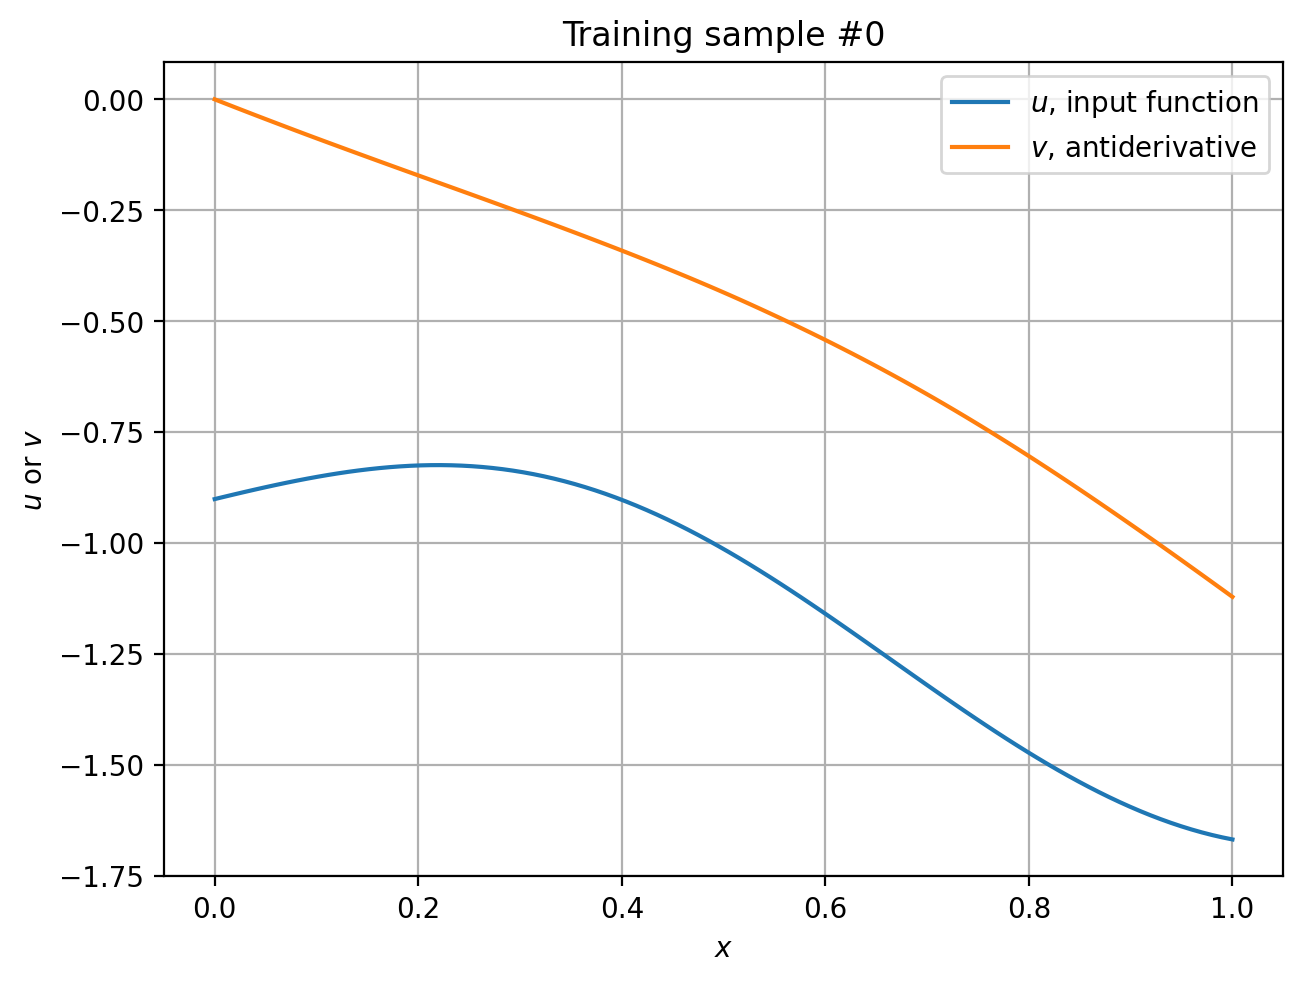

In [16]:
sample_index = 0  # 0~149

fig, ax = plt.subplots()
ax.plot(y_train, u_train[sample_index], label=R"$u$, input function")
ax.plot(y_train, v_train[sample_index], label=R"$v$, antiderivative")
ax.legend()
ax.set(
    xlabel=R"$x$",
    ylabel=R"$u$ or $v$",
    title=f"Training sample #{sample_index}",
)
ax.grid()
pass

DeepONet의 구조를 구현합니다.

In [17]:
class DeepONet(nn.Module):
    branch_net_features: Sequence[int]
    trunk_net_features: Sequence[int]
    activation: Callable = jnp.tanh

    @nn.compact
    def __call__(self, u, y):
        branch_net_value = MLP(
            self.branch_net_features,
            activation=self.activation,
            name="branch_net",
        )(u)
        trunk_net_value = MLP(
            self.trunk_net_features,
            activation=self.activation,
            name="trunk_net",
        )(y)
        bias = self.param("bias", nn.initializers.zeros_init(), ())
        return jnp.dot(branch_net_value, trunk_net_value) + bias

지금까지 사용했던 `compact` 방식 외에 또 다른 방식이 있습니다.

`setup` + `__call__`을 같이 사용하는 이 방식은 `compact` 방식에 비해 코드가 더 장황해지지만, PyTorch의 방식과 조금 더 닮아서 PyTorch에 익숙한 경우 더 작성하기 쉬울 수도 있습니다.

In [18]:
class DeepONetWithSetup(nn.Module):
    branch_net_features: Sequence[int]
    trunk_net_features: Sequence[int]
    activation: Callable = jnp.tanh

    def setup(self):
        self.branch_net = MLP(
            self.branch_net_features,
            activation=self.activation,
            name="branch_net",
        )
        self.trunk_net = MLP(
            self.trunk_net_features,
            activation=self.activation,
            name="trunk_net",
        )
        self.bias = self.param("bias", nn.initializers.zeros_init(), ())

    def __call__(self, u, y):
        branch_net_value = self.branch_net(u)
        trunk_net_value = self.trunk_net(y)

        return jnp.dot(branch_net_value, trunk_net_value) + self.bias

In [19]:
# 파라미터 모양 확인
model = DeepONet(branch_net_features=(40, 40), trunk_net_features=(40, 40))

key = jax.random.key(78)
params = model.init(key, u_train[0], y_train[0])
jax.tree.map(lambda x: x.shape, params)
# bias 하나 (scalar), Dense 2개 이런식으로 파라미터가 쌓여있어요.

{'params': {'bias': (),
  'branch_net': {'Dense_0': {'bias': (40,), 'kernel': (100, 40)},
   'Dense_1': {'bias': (40,), 'kernel': (40, 40)}},
  'trunk_net': {'Dense_0': {'bias': (40,), 'kernel': (1, 40)},
   'Dense_1': {'bias': (40,), 'kernel': (40, 40)}}}}

In [20]:
# 모델 세팅
# N_u: u 데이터의 개수, 보통은 150
# m: (aligned) grid의 개수이자 branch net의 입력 크기, 100
# N_y: y 데이터의 개수, 훈련시에는 m이지만, 추론시에는 상관없음

# model.apply: (m,), (1,) -> ()
model = DeepONet(branch_net_features=(40, 40), trunk_net_features=(40, 40))

# (N_u, m), (N_y, 1) -> (N_u, N_y)
batched_model_apply = jax.vmap(
    jax.vmap(model.apply, in_axes=(None, None, 0)), in_axes=(None, 0, None)
) # 벡터화를 2번 했어요. 차원이 2개 추가돼요.

# (N_u, m), (m, 1), (N_u, m) -> ()
def antiderivative_loss(params, u, y, v):
    return ((v - batched_model_apply(params, u, y))**2).mean()
# 여기는 PDE가 하나도 안들어갔어요
# 우리는 data가 있으니까, data를 잘 맞추는 모델을 만들어라를 한거에요.


In [21]:
key = jax.random.key(78)
n_epochs = 20_000
learning_rate = optax.cosine_decay_schedule(1e-3, decay_steps=n_epochs)

params = model.init(key, u_train[0], y_train[0])
optimizer = optax.adam(learning_rate)
optimizer_state = optimizer.init(params)

@jax.jit
def step(params, optimizer_state, u, y, v):
    loss, grads = jax.value_and_grad(antiderivative_loss)(params, u, y, v)
    updates, optimizer_state = optimizer.update(grads, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params, optimizer_state, loss

In [22]:
loss_history = []
for i in tqdm(range(1, n_epochs + 1)):
    params, optimizer_state, loss_value = step(
        params, optimizer_state, u_train, y_train, v_train
    )

    loss_history.append(loss_value.item())
    if i % (n_epochs // 20) == 0:
        tqdm.write(f"Epoch {i}: {loss_value = :g}")

  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 1000: loss_value = 0.000394866
Epoch 2000: loss_value = 0.000440917
Epoch 3000: loss_value = 0.00173296
Epoch 4000: loss_value = 6.42884e-05
Epoch 5000: loss_value = 4.86138e-05
Epoch 6000: loss_value = 3.77255e-05
Epoch 7000: loss_value = 0.000191714
Epoch 8000: loss_value = 3.13402e-05
Epoch 9000: loss_value = 3.6307e-05
Epoch 10000: loss_value = 2.43576e-05
Epoch 11000: loss_value = 2.26403e-05
Epoch 12000: loss_value = 2.11184e-05
Epoch 13000: loss_value = 1.97677e-05
Epoch 14000: loss_value = 1.87211e-05
Epoch 15000: loss_value = 1.79107e-05
Epoch 16000: loss_value = 1.72556e-05
Epoch 17000: loss_value = 1.6739e-05
Epoch 18000: loss_value = 1.63741e-05
Epoch 19000: loss_value = 1.61794e-05
Epoch 20000: loss_value = 1.61393e-05


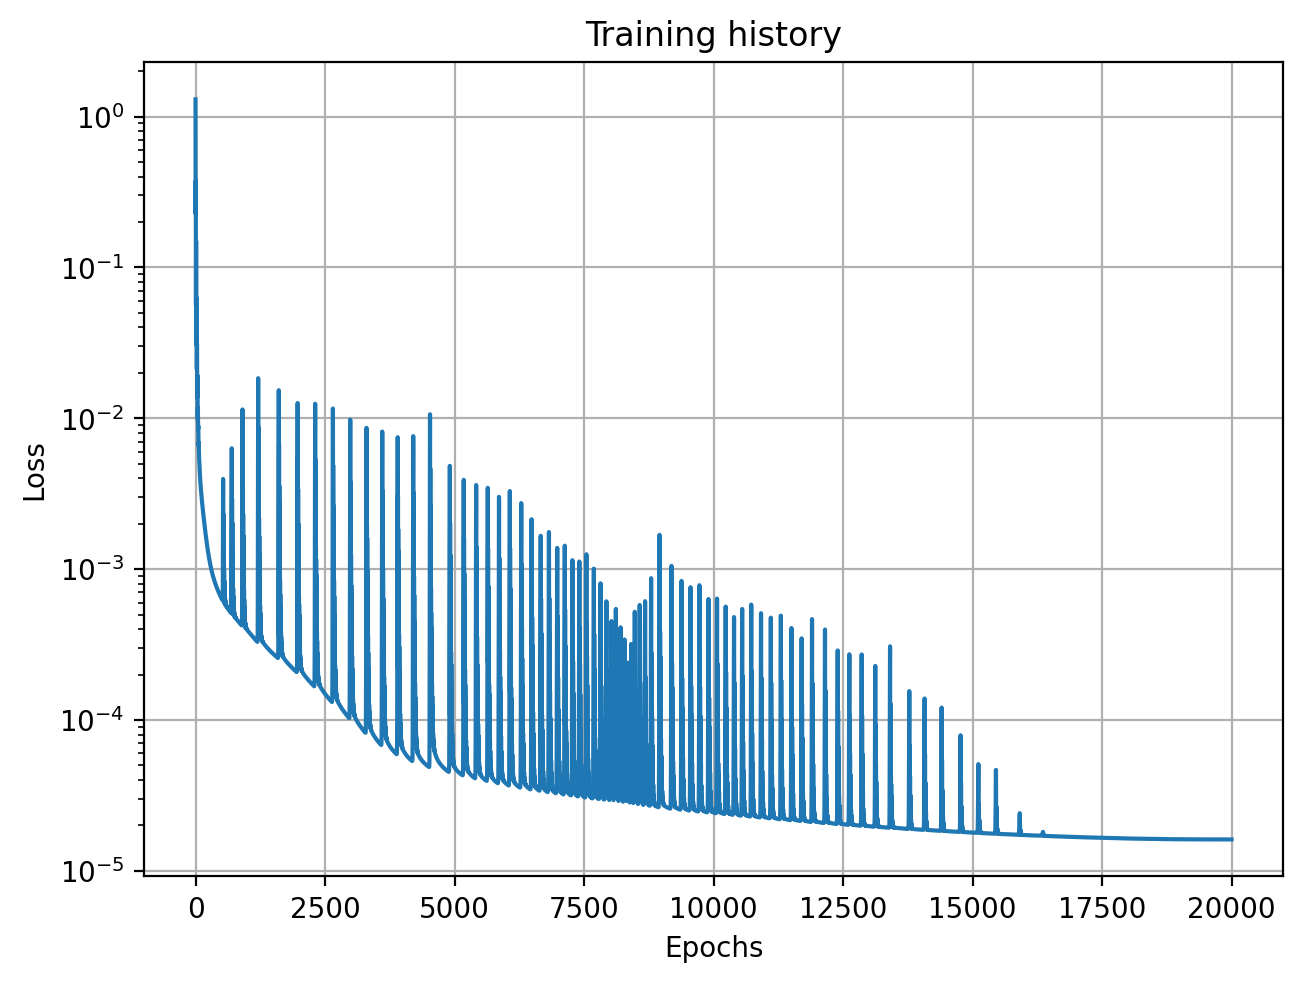

In [23]:
fig, ax = plt.subplots()
ax.semilogy(loss_history)
ax.set(xlabel="Epochs", ylabel="Loss", title="Training history")
ax.grid()
pass

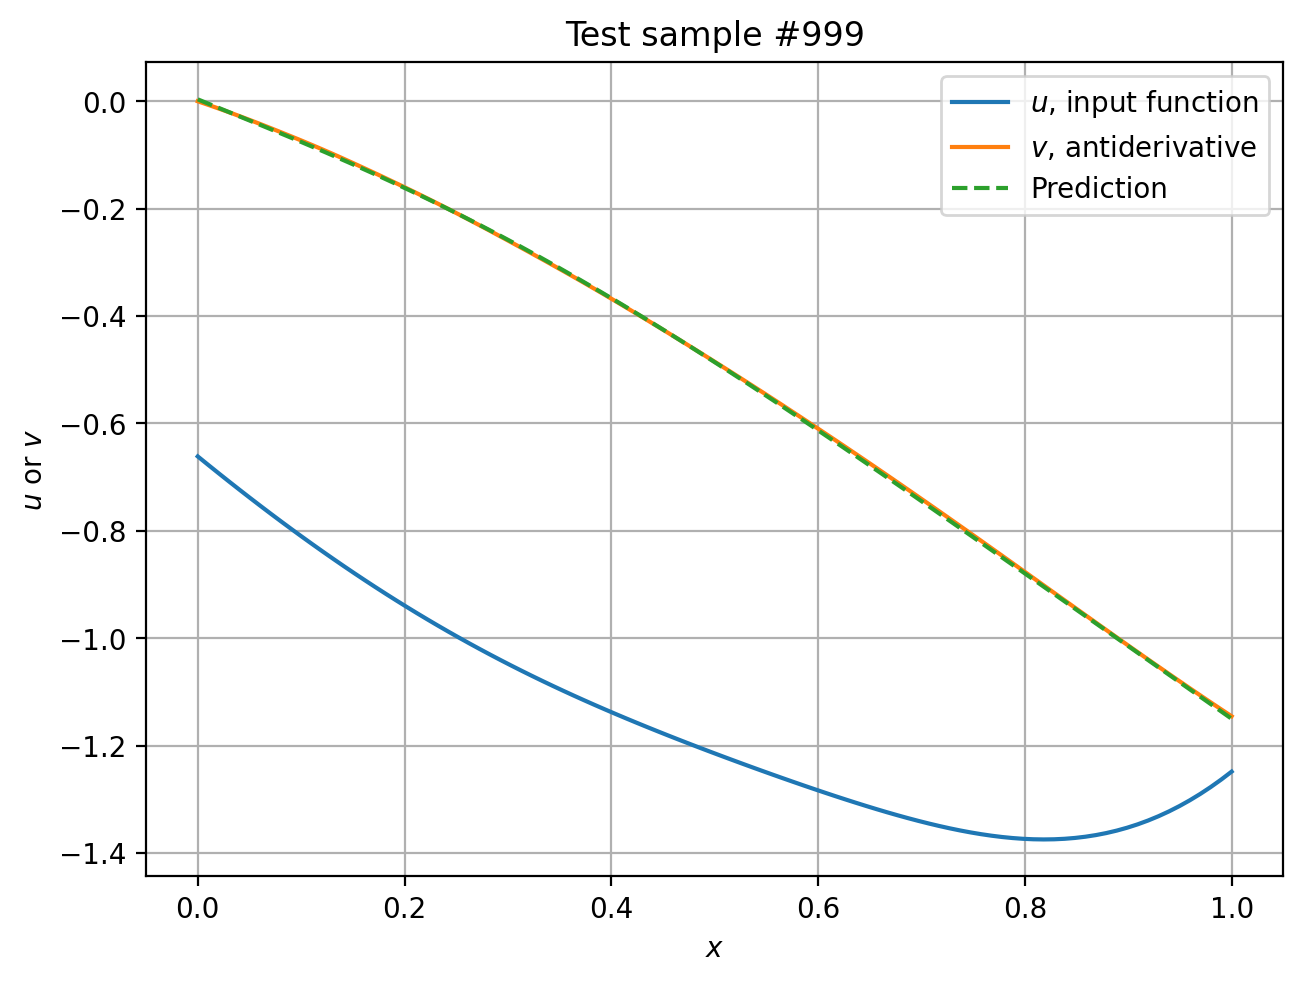

In [24]:
sample_index = 999  # 0~999

y_dense = jnp.linspace(0, 1, 301)[:, jnp.newaxis]  # grid에 없던 값도 입력 가능
v_prediction = batched_model_apply(
    params, u_test[sample_index : sample_index + 1], y_dense
).squeeze()

fig, ax = plt.subplots()
ax.plot(y_test, u_test[sample_index], c="C0", label=R"$u$, input function")
ax.plot(y_test, v_test[sample_index], c="C1", label=R"$v$, antiderivative")
ax.plot(y_dense, v_prediction, c="C2", ls="--", label="Prediction")
ax.legend()
ax.set(
    xlabel=R"$x$",
    ylabel=R"$u$ or $v$",
    title=f"Test sample #{sample_index}",
)
ax.grid()
pass

## 더 보기

JAX, Flax 문서

- [JAX: High-Performance Array Computing — JAX documentation](https://jax.readthedocs.io/en/latest/)
  - [Quickstart — JAX documentation](https://jax.readthedocs.io/en/latest/quickstart.html)
  - [Key Concepts — JAX documentation](https://jax.readthedocs.io/en/latest/key-concepts.html)
  - [Just-in-time compilation — JAX documentation](https://jax.readthedocs.io/en/latest/jit-compilation.html)
  - [Automatic vectorization — JAX documentation](https://jax.readthedocs.io/en/latest/automatic-vectorization.html)
  - [Automatic differentiation — JAX documentation](https://jax.readthedocs.io/en/latest/automatic-differentiation.html)
- [Flax](https://flax.readthedocs.io/en/latest/)
  - [Quick start](https://flax.readthedocs.io/en/latest/quick_start.html)
  - [Flax Basics](https://flax.readthedocs.io/en/latest/guides/flax_fundamentals/flax_basics.html)

더 해보기(예)

- 프로그램의 숫자를 바꿔 가면서 실행해 보기
- 데이터 샘플링을 Sobol 수열 등의 저불일치 수열로 해 보기
- 원 같은 다른 도메인이나 더 복잡한 도메인에 적용해 보기(샘플링 방식, 개수에 주의)
- PINN에 MLP가 아닌 다른 모델을 적용해 보기
- Deep Rits method에서 적분 방식 바꾸기
- ...
